# Chapter 11-4. RNN Timeseries

- Time Series Data
- Apply RNN
    - Many-to-One
    - Data Reading
    - Neural Net Setting
    - Training & Evaluation
- Exercise

---

## Time Series Data

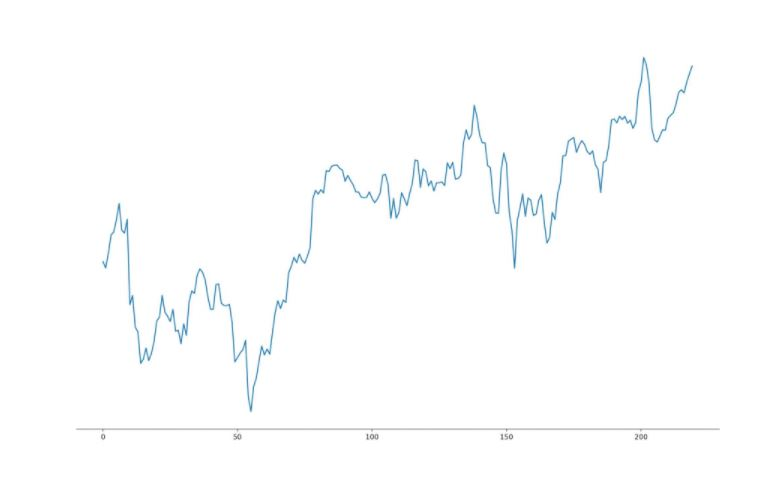

시계열 데이터 (ex. 주가 데이터)
- GOOG - 시가, 종가 시간별로 기록

---

## Apply RNN

### Many to One

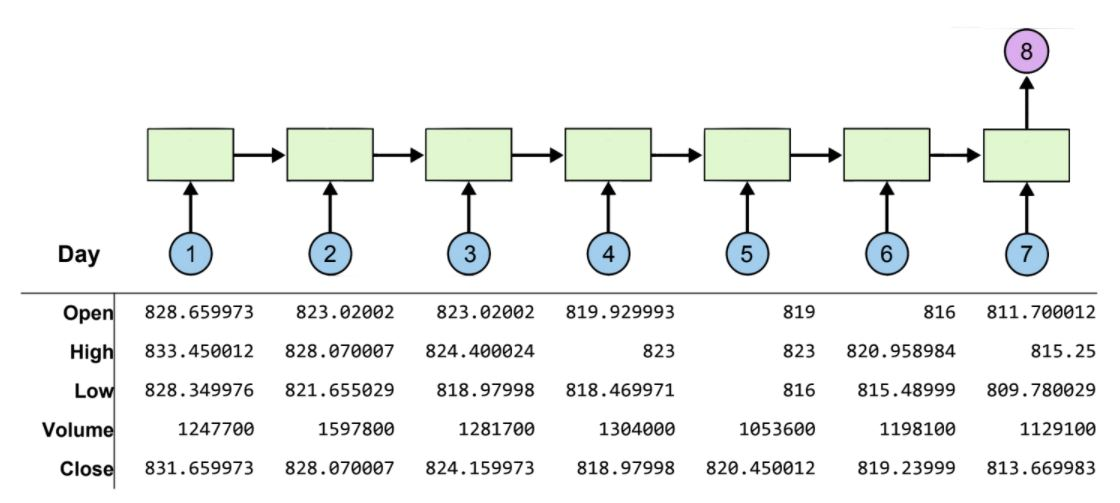

- 7일간의 데이터를 받아서 8일의 종가를 예측
- 8일차의 종가를 예측하기 위해 그 전 일주일 데이터를 보면 될 거라는 전제로 출발 (사실 틀림)
</br>

- 5개의 dim으로 이루어진 데이터 + 그 전 셀에서부터 받은 정보 → 다음 셀의 input이 됨
- 마지막 layer에서 나온 결과가 output이 됨
- network가 8일차의 종가를 바로 맞춘다고 가정하면
    - 결과 vector의 dim은 하나의 값만 가짐 (dim=1짜리 벡터)
    - 문제: 모든 단계의 hidden state도 하나의 값만 가짐(dim=1)
        - 부담: 다섯 개의 input data 처리한 후 하나의 data로 압축해서 다음 레이어에 넣어 줌
    - 해결책: **FC 레이어 연결** (일반적인 모델)
        - 데이터를 유통하기 위해 hidden state를 보장해 줌
        - 출력되는 단계에서는 n(dim of hidden state)의 출력된 벡터를 가지고 FC로 연결해서 그 레이어의 output이 종가를 맞추도록 함
        - → 부담 분산시킴

---

## Data Reading

### hyper parameters
```python
seq_length = 7
data_dim = 5 # 시가, 최저가, 최고가, 거래가, 종가
hidden_dim = 10
output_dim = 1 # 모델이 맞춰야 되는 것의 개수 (하나! 종가)
learning_rate = 0.01
iterations = 500
```

### load data
```python
load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order # 시간 역순으로 modering
```

### split train-test set
```python
train_size = int(len(xy) * 0.7) # 70%(train set)만 남기고, 나머지는 test set
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]
```

### scaling data

```python
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)
```

- scaling 해 주는 이유
    - 거래량(백만 정도) - 주가(800 정도)로 이루어진 데이터 
    - 모델 입장에서 scale 다른 것이 부담
    - 부담 없애 주기 위해 모두 **[0, 1] 사이의 상대값**으로 전환
    - 학습의 부담을 덜어 주는 scale

### make train-test dataset to input

```python
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)
```

### convert to tensor

```python
X_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)
```

### 어떻게 scaling 하는지

scaling function for input data

```python
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)
```

최댓값과 최솟값 사이를 선형으로 그어서 linear로 나눔


### 어떻게 dataset 만드는지

make dataset to train
make dataset to input

```python
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)
```
    
레이블과 학습의 대상이 되는 값들을 나누어 줌

### NN 선언

```python
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x
    
net = Net(data_dim, hidden_dim, output_dim, 1)
```


loss & optimizer setting

```python
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
```

- 간단하게 LSTM layer 선언 후 RNN 함수에 넣어 줌
- fc 선언하여 prediction 할 때 RNN 결과를 fc에 연결하여 return
- 간단하게 네트워크 선언
- 실수값이기 때문에 MSEloss 선언하여 loss 계산
- Adam optimization 이용

### Training & Evaluation

start training

```python
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())
```

- iteration 수 만큼 반복하면서 최적회
- test set floating
- 그에 대한 prediction도 floating
- 파란색 선: test set 8일차 종가
    - 주황색 선: 그에 대한 prediction
    
    
- 하지만 실재로는 안 됨
    - 변동 일으키는 변수 굉장히 많음
    - 이 5개의 feature만으로는 주식 시장 변동 X
    - *더 많은 feature 필요*
    - news, twitter 크롤링하여 단어, 감정 분석 후 feature 넣는 경우도 있음

---

## Full Code

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [3]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [4]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [5]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [6]:
# hyper parameters
seq_length = 7
data_dim = 5 # 시가, 최저가, 최고가, 거래가, 종가
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [7]:
## load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

In [8]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [9]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [10]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038442850113
1 0.18340937793254852
2 0.15106439590454102
3 0.12612313032150269
4 0.10598734766244888
5 0.08915018290281296
6 0.07493706792593002
7 0.06327901780605316
8 0.05449603125452995
9 0.04902385547757149
10 0.04693441465497017
11 0.04731706529855728
12 0.04838264361023903
13 0.04839478060603142
14 0.04633766785264015
15 0.04207771271467209
16 0.036201704293489456
17 0.029662011191248894
18 0.02338656410574913
19 0.018011242151260376
20 0.013800663873553276
21 0.010714655742049217
22 0.008532221429049969
23 0.0069765085354447365
24 0.0058244820684194565
25 0.004987423773854971
26 0.004524713382124901
27 0.004554683342576027
28 0.005089898128062487
29 0.00592096708714962
30 0.006684893276542425
31 0.007072674576193094
32 0.006973991170525551
33 0.006471904926002026
34 0.005753521341830492
35 0.005014693830162287
36 0.004395292140543461
37 0.003953744191676378
38 0.0036766387056559324
39 0.003510984592139721
40 0.0034013083204627037
41 0.0033151081297546625
42 0.00324889435

In [11]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.0012744442792609334
1 0.001273985137231648
2 0.0012735280906781554
3 0.0012730732560157776
4 0.001272620283998549
5 0.001272169523872435
6 0.0012717206263914704
7 0.001271273591555655
8 0.0012708287686109543
9 0.0012703855754807591
10 0.0012699438957497478
11 0.0012695041950792074
12 0.00126906658988446
13 0.0012686302652582526
14 0.0012681959196925163
15 0.0012677627382799983
16 0.0012673314195126295
17 0.0012669018469750881
18 0.0012664739042520523
19 0.001266047009266913
20 0.0012656220933422446
21 0.001265198108740151
22 0.0012647761031985283
23 0.0012643546797335148
24 0.001263935468159616
25 0.0012635173043236136
26 0.0012631003046408296
27 0.0012626847019419074
28 0.001262270612642169
29 0.0012618571054190397
30 0.0012614454608410597
31 0.0012610347475856543
32 0.0012606250820681453
33 0.0012602168135344982
34 0.0012598098255693913
35 0.001259403652511537
36 0.0012589985271915793
37 0.0012585946824401617
38 0.0012581920018419623
39 0.0012577902525663376
40 0.0012573890853673

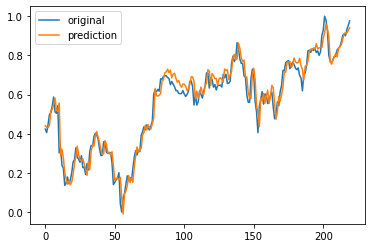

In [12]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()